## 特徴量のカンペはこちら ⇒ https://docs.google.com/spreadsheets/d/1T59ieP110cFg8MfOtIbW2M60iWuSwnIf/edit?usp=share_link&ouid=111727008586725963366&rtpof=true&sd=true

## Kaggle用データのインポート

In [45]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"droeloe","key":"c330037c8e955090c87e6872ec333b32"}'}

In [46]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip -o {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 22.7MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## ライブラリのインポート

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from numpy import mean, std
!pip install optuna
import optuna

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import mean_squared_error

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from scipy.special import boxcox1p
from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import FeatureUnion
import warnings


### User modules

In [48]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [49]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [50]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [51]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [52]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [53]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])

  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]

  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [54]:
# column_transformer 利用後のカラム名を取得する関数
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names
# get_feature_names(preprocessor)

In [55]:
def scatter_hist(data, xlabel, ylabel):
  x = data[xlabel]
  y = data[ylabel]

  fig = plt.figure(figsize=(8,8))
  gs = gridspec.GridSpec(3, 3)
  ax_main = plt.subplot(gs[1:3, :2])
  ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
  ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

  ax_main.scatter(x,y,marker='.')
  ax_main.set(xlabel=xlabel, ylabel=ylabel)

  ax_xDist.hist(x,bins=100,align='mid')
  ax_xDist.set(ylabel='count')
  ax_xCumDist = ax_xDist.twinx()
  ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
  ax_xCumDist.tick_params('y', colors='r')
  ax_xCumDist.set_ylabel('cumulative',color='r')

  ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
  ax_yDist.set(xlabel='count')
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
  ax_yCumDist.tick_params('x', colors='r')
  ax_yCumDist.set_xlabel('cumulative',color='r')

  plt.show()

## データのダウンロード

In [56]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

## target と 自動分類が上手くいかないカラムの設定

In [57]:
# target と 自動分類が上手くいかないカラムの設定
target = "SalePrice"
all_data["MSSubClass"] = all_data["MSSubClass"].astype("object")

### categorical や numerical の定義

In [58]:
def get_num_cat_column_names(df, target):
  feature_cols = df.columns.drop(target)
  categorical_cols = []
  numerical_cols = []
  for i in feature_cols:
      if df[i].dtype=='object':
          categorical_cols.append(i)
      else:
          numerical_cols.append(i)

  return categorical_cols, numerical_cols

### BoxCox変換する特徴量を決める

In [59]:
def get_skewed_column_names(df, numerical_cols, threshold=0.75):
  skewed_feats = df[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew' :skewed_feats})
  skewness = skewness[skewness.abs() > threshold]
  skewness.dropna(inplace=True)
  skewed_features = skewness.index.copy()

  new_numerical_cols = numerical_cols.copy()
  for col in skewed_features:
    new_numerical_cols.remove(col)

  return skewed_features, new_numerical_cols

In [60]:
def submit_results(model, train_X, train_y):
  model.fit(train_X, train_y)
  scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
  score = mean(scores["test_score"])
  print(f"score = {score}")
  y_pred = model.predict(test_X)
  output = pd.DataFrame({'Id': test["Id"],
                        'SalePrice': y_pred})

  path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
  output.to_csv(path, index=False)
  display(output)

In [61]:
def split_data(data, target):
  train_len = data.shape[0]-data[target].isna().sum()
  train_X = data.iloc[:train_len][data.columns.drop(target)]
  train_y = pd.DataFrame(data.iloc[:train_len][target], columns=[target])
  test_X = data.iloc[train_len:][data.columns.drop(target)]

  return train_X, train_y, test_X

In [62]:
#Validation function
n_folds = 5

def get_rmse_CV(model, train_X, train_y):
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = cross_validate(model, train_X, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
    rmse = np.sqrt(-scores["test_score"])

    return(rmse)

## 外れ値に対する処理の定義

In [63]:
class CleanOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0, strategy="mean"):
        self.contamination = contamination
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.contamination==0: return self
        self.lof = LocalOutlierFactor(contamination=self.contamination, novelty=True)
        self.lof.fit(X)
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        if self.contamination==0: return X
        idx_outlier = self.lof.predict(X)==-1
        X[idx_outlier, :] = np.nan # set NaN to outlier value

        simple_imputer = SimpleImputer(strategy=self.strategy)
        X = simple_imputer.fit_transform(X) # fill outlier value usin simple_imputer

        return X

In [64]:
class SigmaOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, sigma=3):
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        X = pd.DataFrame(X)
        for col in X.columns:
          m = np.mean(X[col])
          sd = np.std(X[col])
          X[X[col]>(sd*self.sigma+m)] = m + sd * self.sigma
          X[X[col]<(sd*self.sigma*-1+m)] = m - sd * self.sigma

        return X.to_numpy()

### 特徴量エンジニアリングの処理の定義

In [65]:
def feature_engineering(data):
  # add new feature
  data["YearSinceRemodel"] = data["YrSold"] - data["YearBuilt"] # ここで新しい特徴量を追加する
  data['BsmtFinType1_Unf'] = 1*(data['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
  data['HasWoodDeck'] = (data['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
  data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond'] # ここで新しい特徴量を追加する
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] # ここで新しい特徴量を追加する
  data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  data['YrBltAndRemod'] = data['YearBuilt'] + data['YearRemodAdd']
  data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
  data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
  data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

  # delete features
  data = data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
  return data

## 基本的な処理

In [66]:
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KeyboardInterrupt: ignored

# 比較

## SimpleImputer と KNNImputerの比較 ⇒ ほぼ変化なし

In [ ]:
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer_KNN = Pipeline(steps=[('num_imputer', KNNImputer(n_neighbors=5, metric='nan_euclidean')), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer_KNN = Pipeline(steps=[('num_imputer', KNNImputer(n_neighbors=5, metric='nan_euclidean')), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer_KNN = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor_KNN = ColumnTransformer(transformers=[("num", numeric_transformer_KNN, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer_KNN, categorical_cols), ("skew", skewed_transformer_KNN, skewed_features)])

# Pipeline を定義する
pipeline_KNN = Pipeline([
    ('preprocessing', preprocessor_KNN),
    ('model', lgb.LGBMRegressor())
])


# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = get_rmse_CV(pipeline_KNN, train_X, train_y)
print("LGBM(KNN) score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

## One-hot と ラベルエンコーディングの比較 ⇒ 良くなった

In [ ]:
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer_sub = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer_sub = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer_sub = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
pipeline_sub = ColumnTransformer(transformers=[("num", numeric_transformer_sub, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer_sub, categorical_cols), ("skew", skewed_transformer_sub, skewed_features)])

# Pipeline を定義する
pipeline_sub = Pipeline([
    ('preprocessing', pipeline_sub),
    ('model', lgb.LGBMRegressor())
])


# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = get_rmse_CV(pipeline_sub, train_X, train_y)
print("LGBM(sub) score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

## Scalerの有無（StandardScaler）⇒ scalerない方が良い

In [ ]:
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

## 外れ値の除外（除外したほうが良い）
Best parameters:  {'contamination_num': 0.002148248981503568, 'contamination_skew': 8.630333857546982e-06}
Best score:  27925.729263493722

In [ ]:
# ハイパーパラメータ最適化の目的関数を定義
def objective(trial):
    # CleanOutlierのcontaminationの最適化範囲を指定
    contamination_num = trial.suggest_loguniform('contamination_num', 1e-7, 0.1)
    contamination_skew = trial.suggest_loguniform('contamination_skew', 1e-7, 0.1)

    # 数値変数の前処理パイプライン（contaminationを最適化する）
    numeric_transformer = Pipeline(steps=[
        ('num_imputer', SimpleImputer(strategy='median')),
        ("outlier", CleanOutlier(contamination=contamination_num, strategy="mean"))
    ])

    # 歪度のある数値変数の前処理パイプライン（contaminationを最適化する）
    skewed_transformer = Pipeline(steps=[
        ('num_imputer', SimpleImputer(strategy='median')),
        ("outlier", CleanOutlier(contamination=contamination_skew, strategy="mean")),
        ("power", PowerTransformer(method='yeo-johnson'))
    ])

    # カテゴリ変数の前処理パイプライン
    categorical_transformer = Pipeline(steps=[
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("encoder", OneHotEncoder(handle_unknown='ignore'))
    ])

    # 全体の前処理パイプライン
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, list(set(numerical_cols) - set(skewed_features))),
        ("cat", categorical_transformer, categorical_cols),
        ("skew", skewed_transformer, skewed_features)
    ])

    # モデルの定義（例：LGBMRegressor）
    model = lgb.LGBMRegressor()

    # パイプラインを定義
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    # パイプラインを評価（例：RMSEをスコアとする）
    score = get_rmse_CV(pipeline, train_X, train_y).mean()

    return score

# Optunaによる最適化
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 最適なハイパーパラメータとスコアの表示
best_params = study.best_params
best_score = study.best_value
print("Best parameters: ", best_params)
print("Best score: ", best_score)

## 少し改造した基本的なコード

In [67]:
def get_variable_types_threshold(df, target, skewness_threshold=0.75):
    numeric_cols = []
    skewed_cols = []
    categorical_cols = []

    for column in df.columns.drop(target):
        if np.issubdtype(df[column].dtype, np.number):
            if abs(skew(df[column])) > skewness_threshold:
                skewed_cols.append(column)
            else:
                numeric_cols.append(column)
        elif df[column].dtype == 'object':
            categorical_cols.append(column)

    return numeric_cols, skewed_cols, categorical_cols

In [ ]:
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリングしたものを学習用データとテストデータに分ける
train_X, train_y, test_X = split_data(feature_engineering(all_data_fe), target)

numeric_cols, skewed_cols, categorical_cols = get_variable_types_threshold(feature_engineering(all_data_fe), target, skewness_threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_cols)])

# Pipelineを定義
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

## ハイパーパラメータチューニング

### 手動チューニング
下記が参考になりそう
https://qiita.com/c60evaporator/items/351188110f328ff921b9
- 影響度の大きなパラメータ（葉の数、木の深さ。などを設定し、その後別のパラメータを微修正する）

In [68]:
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 使用するチューニング対象外のパラメータ
params = {
    'objective': 'regression',  # 最小化させるべき損失関数
    'metric': 'rmse',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
    'random_state': 42,  # 乱数シード
    'boosting_type': 'gbdt',
    'n_estimators': 10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
    'verbose': -1,  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
    'early_stopping_round': 10  # ここでearly_stoppingを指定
    }
# モデル作成
model = lgb.LGBMRegressor(**params)

# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリングしたものを学習用データとテストデータに分ける
train_X, train_y, test_X = split_data(feature_engineering(all_data_fe), target)

# Pipelineを定義
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor(**{'max_depth': 10, 'min_data_in_leaf': 0, 'num_leaves': 10, "colsample _bytree":0.5, "subsample":0.5, "max_bin":100 , "lambda_l1":10 , "metric":'rmse'}))
])

train_X_preprocessed = pipeline["preprocessing"].fit_transform(train_X)
test_X_preprocessed = pipeline["preprocessing"].fit_transform(test_X)

cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
iterator = cv.split(train_X_preprocessed, train_y)

# イテレータのnextメソッドを使用して最初の訓練データと検証データのインデックスを取得
cv_index, val_index = next(iterator)
X_cv, X_val = train_X_preprocessed[cv_index], train_X_preprocessed[val_index]
y_cv, y_val = train_y.iloc[cv_index, :], train_y.iloc[val_index, :]

# 学習時fitパラメータ指定
fit_params = {
    'eval_set': [(X_val, y_val)]  # early_stopping用のデータeval_setを渡す
    }

### ざっくりとパラメータの変化に対する性能の変化を観察する（過学習していないことに気を配る）

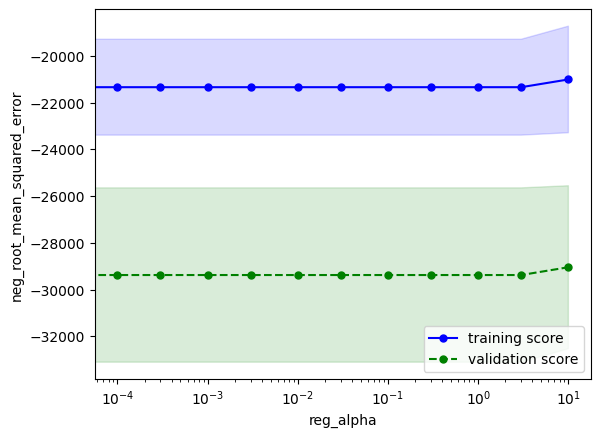

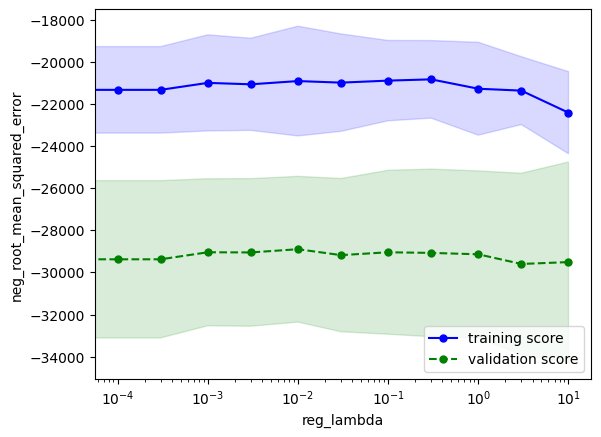

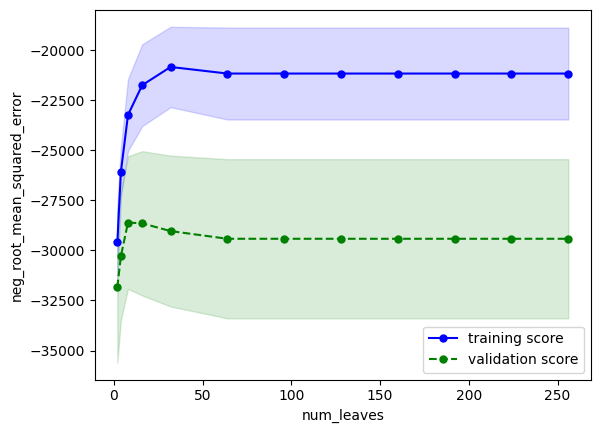

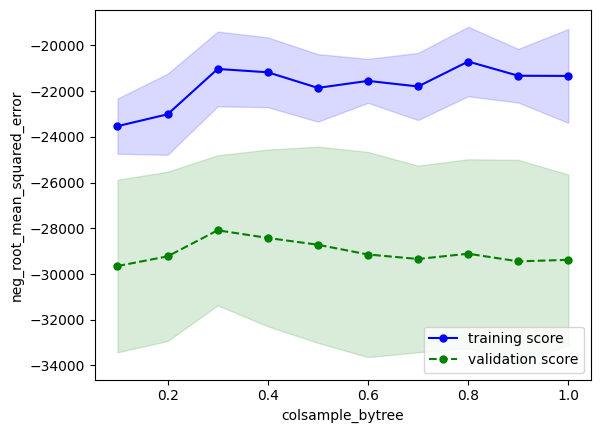

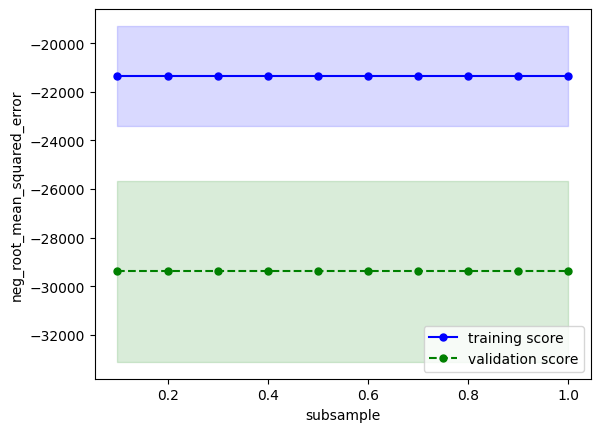

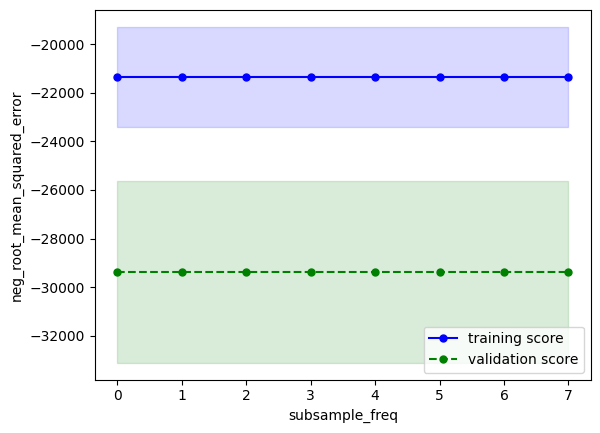

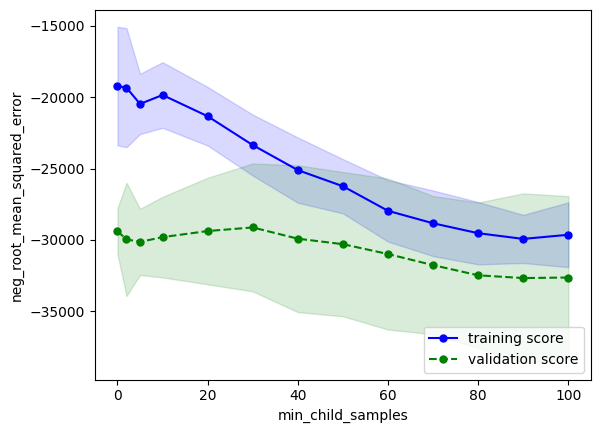

In [69]:
from sklearn.model_selection import validation_curve
scoring = 'neg_root_mean_squared_error'
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X_cv, y=y_cv,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

### グラフを見ながらパラメータを微修正

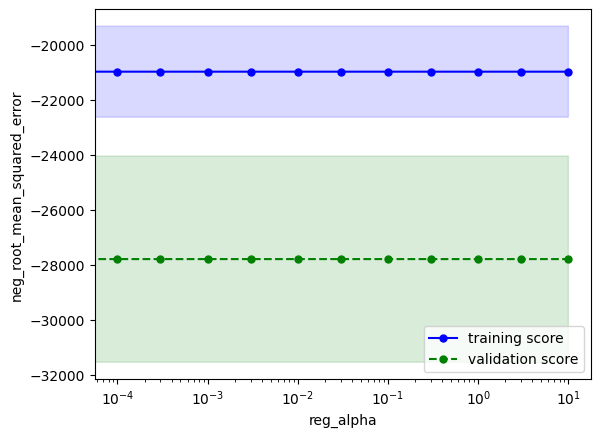

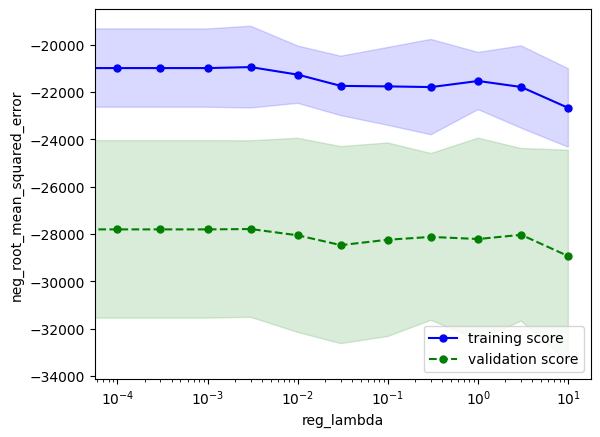

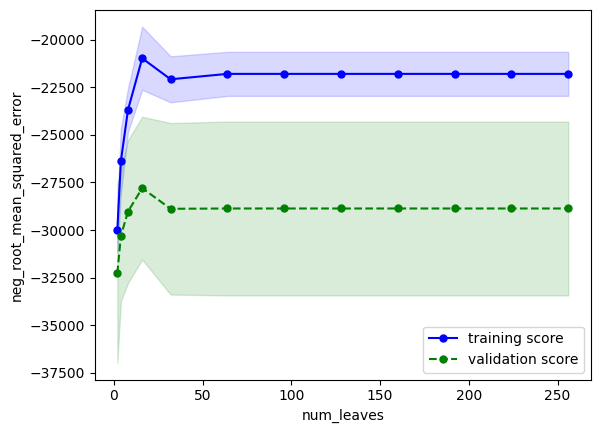

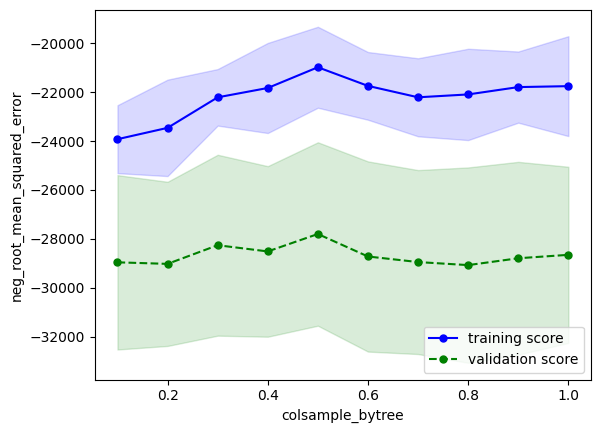

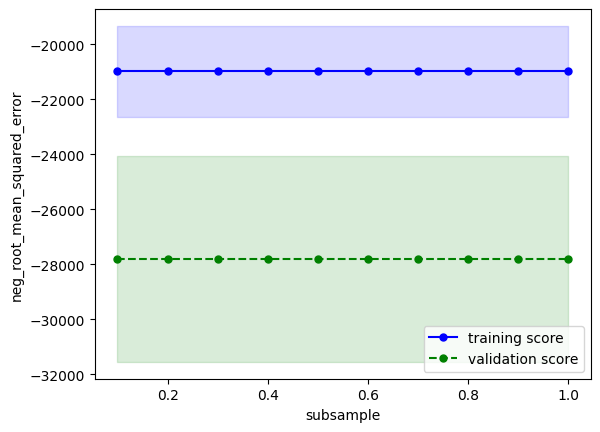

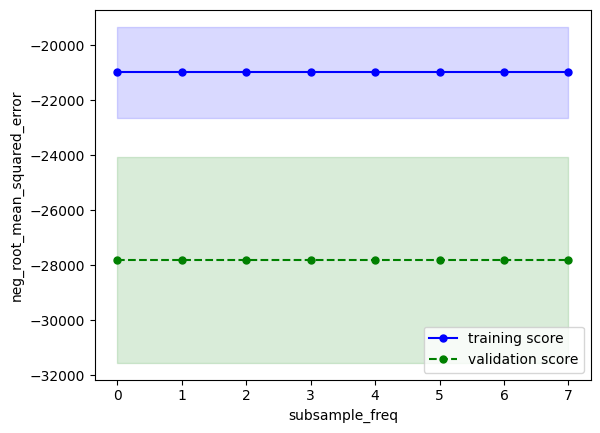

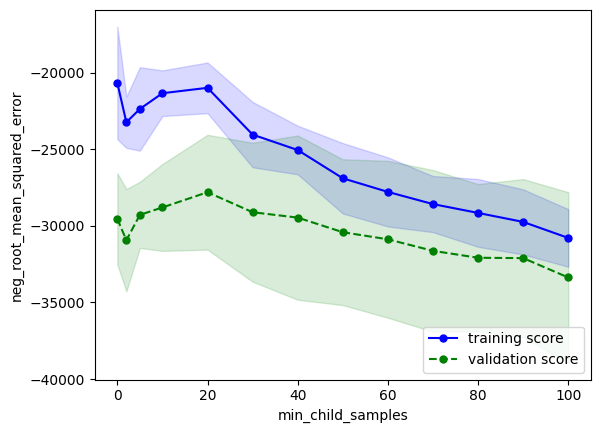

In [72]:
model.set_params(min_child_samples=20, num_leaves=16, colsample_bytree=0.5)

for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X_cv, y=y_cv,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

In [75]:
params = {
    'objective': 'regression',  # 最小化させるべき損失関数
    'metric': 'rmse',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
    'random_state': 42,  # 乱数シード
    'boosting_type': 'gbdt',
    'n_estimators': 10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
    'verbose': -1,  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
    "min_child_samples":20,
    "num_leaves":16,
    "colsample_bytree":0.5
    }
# モデル作成
model = lgb.LGBMRegressor(**params)

scores = cross_validate(model, train_X_preprocessed, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
model.fit(train_X_preprocessed, train_y)
y_pred = model.predict(test_X_preprocessed)
output = pd.DataFrame({'Id': test["Id"],
                      'SalePrice': y_pred})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
display(output)

,Id,SalePrice
0,1461,131158.944995
1,1462,172073.301768
2,1463,170555.446464
3,1464,195410.600414
4,1465,174043.479611
...,...,...
1454,2915,87137.540066
1455,2916,88906.930083
1456,2917,189176.998661
1457,2918,116306.576005


In [77]:
np.mean(scores["test_score"])

-1119699857.1263576